<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/code_blocks/Adaptive_EMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install vecstack==0.4.0 -q
!pip install pyotp --q
!pip install smartapi-python==1.4.1 --q
!pip install logzero --q

  Preparing metadata (setup.py) ... done


In [ ]:
# package import statement
from SmartApi import SmartConnect #or from SmartApi.smartConnect import SmartConnect
import pyotp
from logzero import logger
import time
import os
import urllib
import json
import pandas as pd
import datetime as dt

api_key = 'xOHnB7MG'
username = 'M55123447'
pwd = '1471'
smartApi = SmartConnect(api_key)
try:
    token = "GJZACUQI2TTAIBHBA34XNFJURQ"
    totp = pyotp.TOTP(token).now()
except Exception as e:
    logger.error("Invalid Token: The provided token is not valid.")
    raise e

correlation_id = "abcde"
data = smartApi.generateSession(username, pwd, totp)

if data['status'] == False:
    logger.error(data)

else:
    # login api call
    # logger.info(f"You Credentials: {data}")
    authToken = data['data']['jwtToken']
    refreshToken = data['data']['refreshToken']
    # fetch the feedtoken
    feedToken = smartApi.getfeedToken()
    # fetch User Profile
    res = smartApi.getProfile(refreshToken)
    smartApi.generateToken(refreshToken)
    res=res['data']['exchanges']
#Download Nifty50 Index Data
params = {
           "exchange": "NSE",
           "symboltoken": '99926000',
           "interval": "ONE_DAY",
           "fromdate": (dt.datetime(2019, 3, 7).strftime('%Y-%m-%d %H:%M')),
           "todate": (dt.datetime.today().strftime('%Y-%m-%d %H:%M'))
         }
nifty_data = smartApi.getCandleData(params)
nifty_data_format= pd.DataFrame(nifty_data["data"],
                               columns = ["Date","Open","High","Low","Close","Volume"])
nifty_data_format.set_index("Date",inplace=True)
nifty_data_format.index = pd.to_datetime(nifty_data_format.index)
nifty_data_format.index = nifty_data_format.index.tz_localize(None)
nifty_data_format.head(2)

,Open,High,Low,Close,Volume
Date,,,,,
2020-07-07,10802.85,10813.80,10689.70,10799.65,0
2020-07-08,10818.65,10847.85,10676.55,10705.75,0


In [ ]:
import pandas as pd
import numpy as np

def calculate_market_omega(prices, min_period=6, max_period=50):
    """
    Calculates the Instantaneous Frequency (Omega) using Don K. Mak's
    4-point and 5-point trigonometric methods.

    Parameters:
    prices (pd.Series): Series of closing prices (smoothed).
    min_period (int): Minimum valid cycle length (to filter noise).
    max_period (int): Maximum valid cycle length (to filter trends).

    Returns:
    pd.Series: The Omega values.
    """
    # Initialize variables
    omegas = []
    # Convert series to list for faster indexing in loop
    p = prices.values

    for i in range(len(p)):
        # We need at least 5 bars of history
        if i < 5:
            omegas.append(0)
            continue

        # Get recent 5 prices (p0 is current, p1 is 1 bar ago, etc.)
        p0 = p[i]
        p1 = p[i-1]
        p2 = p[i-2]
        p3 = p[i-3]
        p4 = p[i-4]

        curr_omega = 0.0

        # --- METHOD 1: 4-Point Formula ---
        # Formula: 2 * arcsin( 0.5 * sqrt(3 - (p0-p3)/(p1-p2)) )

        numerator_4pt = p0 - p3
        denominator_4pt = p1 - p2

        # Check for division by zero or tiny denominator
        if abs(denominator_4pt) > 0.0001:
            ratio = numerator_4pt / denominator_4pt
            term_inside_sqrt = 3 - ratio

            if term_inside_sqrt >= 0:
                sqrt_val = np.sqrt(term_inside_sqrt)

                # Check arcsin domain [-1, 1]
                if abs(0.5 * sqrt_val) <= 1:
                    curr_omega = 2 * np.arcsin(0.5 * sqrt_val)

        # --- METHOD 2: 5-Point Formula (Fallback) ---
        # If 4-point failed (result is 0) or produced invalid result, try 5-point
        # Formula: arccos( 0.5 * (p0-p4)/(p1-p3) )

        if curr_omega == 0.0:
            numerator_5pt = p0 - p4
            denominator_5pt = p1 - p3

            if abs(denominator_5pt) > 0.0001:
                ratio_5pt = 0.5 * (numerator_5pt / denominator_5pt)

                # Check arccos domain [-1, 1]
                if abs(ratio_5pt) <= 1:
                    curr_omega = np.arccos(ratio_5pt)

        # --- FILTERING ---
        # Filter out noise (frequencies that are too high or too low)
        # Omega = 2*pi / Period
        # If period is too small (high freq noise), clamp it
        # If period is too large (trend), clamp it

        if curr_omega < (2 * np.pi / max_period):
            curr_omega = 0 # Too slow (trend)
        elif curr_omega > (2 * np.pi / min_period):
            curr_omega = 0 # Too fast (noise)

        # If calculation failed entirely, use previous value
        if curr_omega == 0 and len(omegas) > 0:
            curr_omega = omegas[-1]

        omegas.append(curr_omega)

    return pd.Series(omegas, index=prices.index)

# ==========================================
# HOW TO USE IN REAL TRADING
# ==========================================

# 1. Load your data
df = nifty_data_format.copy()

# 2. IMPORTANT: Smooth the price first!
# Mak emphasizes calculating frequency on *smoothed* data to remove tick noise.
# We use a standard EMA(5) or EMA(7) for this pre-smoothing.
df['Smooth_Price'] = df['Close'].ewm(span=3, adjust=False).mean()
# Create a high-pass filter (Price minus low frequency trend)
# This leaves only the Cycle + Noise, which is what we want to measure
#df['Detrended_Price'] = df['Close'] - df['Close'].rolling(window=20).mean()

# Now calculate Omega on this detrended series
#df['Real_Omega'] = calculate_market_omega(df['Detrended_Price'])
# 3. Calculate Real Omega
df['Real_Omega'] = calculate_market_omega(df['Smooth_Price'])

# 4. Use this Real Omega in your Adaptive EMA function
# (Paste the Adaptive EMA function from the previous chat here)
# df = calculate_adaptive_ema(df, omega_col='Real_Omega')

print(df[['Close', 'Real_Omega']].tail())

               Close  Real_Omega
Date                            
2025-12-19  25966.40    0.494102
2025-12-22  26172.40    0.538221
2025-12-23  26177.15    0.538221
2025-12-24  26142.10    0.805384
2025-12-26  26042.30    0.618736


In [ ]:
df

,Open,High,Low,Close,Volume,Detrended_Price,Real_Omega
Date,,,,,,,
2020-07-07,10802.85,10813.80,10689.70,10799.65,0,NaN,0.000000
2020-07-08,10818.65,10847.85,10676.55,10705.75,0,NaN,0.000000
2020-07-09,10755.55,10836.85,10733.00,10813.45,0,NaN,0.000000
2020-07-10,10764.10,10819.40,10713.00,10768.05,0,NaN,0.000000
2020-07-13,10851.85,10894.05,10756.05,10802.70,0,NaN,0.000000
...,...,...,...,...,...,...,...
2025-12-19,25911.50,25993.35,25880.45,25966.40,0,-27.2925,0.622024
2025-12-22,26055.85,26180.70,26047.80,26172.40,0,168.0625,0.826919
2025-12-23,26205.20,26233.55,26119.05,26177.15,0,158.1950,0.826919


In [ ]:
import pandas as pd
import numpy as np

def calculate_adaptive_ema(df):
    """
    Calculates Don K. Mak's Adaptive EMA.
    Requires 'Close' and 'Omega' (Frequency) columns in the dataframe.
    """

    # 1. Initialize Alpha column
    # Formula: alpha = 0.66/omega - 0.16
    # We clip the result to ensure it stays between 0.05 and 0.5

    # Note: Avoid division by zero if omega is 0
    clean_omega = df['Real_Omega'].replace(0, 0.001)
    print('1')
    #df['Alpha_Adaptive'] = (0.66 / clean_omega) - 0.16
    df['Alpha_Adaptive'] = (0.1125 / clean_omega) - 0.0625
    # Apply constraints (Eq 3.16)
    # If omega <= 1, Alpha = 0.5
    # If Alpha calculated < 0.05 (very high noise), clamp to 0.05
    df['Alpha_Adaptive'] = np.where(df['Real_Omega'] <= 0.2, 0.5, df['Alpha_Adaptive'])
    #df['Alpha_Adaptive'] = np.where(df['Real_Omega'] <= 1, 0.5, df['Alpha_Adaptive'])
    df['Alpha_Adaptive'] = df['Alpha_Adaptive'].clip(lower=0.05, upper=0.5)
    # 0.5 (equivalent to an EMA length of 3). This is the speed limit for a pure trend.
    # 0.05 (equivalent to an EMA length of 39). This is the "heavy smoothing" mode for pure noise.
    # 2. Calculate Recursive EMA
    # We must iterate because Alpha changes every row
    prices = df['Close'].values
    alphas = df['Alpha_Adaptive'].values
    adaptive_ema = np.zeros_like(prices)
    print('2')
    # Initialize first value
    adaptive_ema[0] = prices[0]

    for i in range(1, len(prices)):
        # y(n) = alpha*x(n) + (1-alpha)*y(n-1)
        adaptive_ema[i] = (alphas[i] * prices[i]) + ((1 - alphas[i]) * adaptive_ema[i-1])

    df['Adaptive_EMA'] = adaptive_ema

    return df

# --- Usage Example ---
# Assuming you have a dataframe with a 'Close' column
# You FIRST need to calculate 'Omega' using the Chapter 6 method (see previous chats)
# For this example, I will generate a dummy Omega
#df = pd.DataFrame({'Close': [100, 101, 102, 101, 100, 99, 98]})




In [ ]:
df = calculate_adaptive_ema(df)


1
2


In [ ]:
df.Alpha_Adaptive.value_counts()

,count
Alpha_Adaptive,
0.050000,91
0.500000,55
0.060610,14
0.156835,12
0.074535,12
...,...
0.056632,1
0.223579,1
0.068392,1


<Axes: xlabel='Date'>

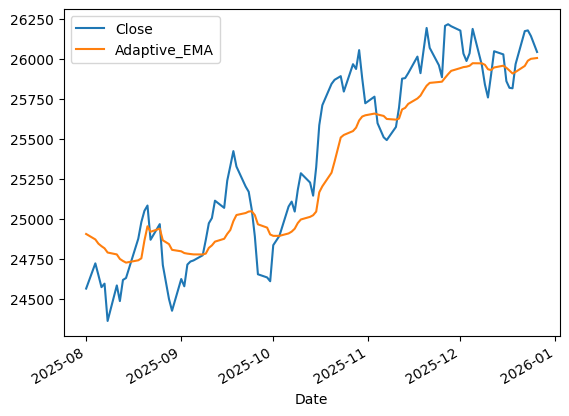

In [ ]:
df[['Close', 'Adaptive_EMA']].tail(100).plot()



In [ ]:
import pandas as pd
import numpy as np

# 1. Helper Function for Mak's Velocity (Chapter 8)
def calculate_cubic_velocity(series):
    # Coefficients: 11/6, -3, 3/2, -1/3
    return ( (11/6)*series - 3*series.shift(1) +
             (3/2)*series.shift(2) - (1/3)*series.shift(3) )

# 2. Helper Function for Mak's Acceleration (Chapter 8)
def calculate_quartic_acceleration(series):
    # Coefficients: 35/12, -26/3, 19/2, -14/3, 11/12
    return ( (35/12)*series - (26/3)*series.shift(1) +
             (19/2)*series.shift(2) - (14/3)*series.shift(3) +
             (11/12)*series.shift(4) )


# --- Step 3: Calculate Indicators on AEMA ---
df['AEMA_Vel'] = calculate_cubic_velocity(df['Adaptive_EMA'])
df['AEMA_Accel'] = calculate_quartic_acceleration(df['Adaptive_EMA'])

# --- Step 4: Generate Signals ---
df['Signal'] = 0

# Buy Trigger: Velocity is Positive AND Acceleration crosses 0 upwards
buy_condition = (
    (df['AEMA_Vel'] > 0) &
    (df['AEMA_Accel'] > 0) &
    (df['AEMA_Accel'].shift(1) < 0)
)

# Sell/Exit Trigger: Velocity crosses below 0
sell_condition = (
    (df['AEMA_Vel'] < 0) &
    (df['AEMA_Vel'].shift(1) > 0)
)

df.loc[buy_condition, 'Signal'] = 1  # Enter Long
df.loc[sell_condition, 'Signal'] = -1 # Exit/Short



# Example Usage:
# df = strategy_adaptive_velocity(df)
# print(df[df['Signal'] != 0].tail())


In [ ]:
df.Signal.tail()

,Signal
Date,
2025-12-19,1
2025-12-22,0
2025-12-23,0
2025-12-24,-1
2025-12-26,1


In [ ]:
def standardize(series, window=100):
    """
    Standardizes a series using a rolling Z-Score.
    Z = (Value - Mean) / StdDev
    Using a rolling window adapts to changing volatility.
    """
    roll = series.rolling(window=window)
    return (series - roll.mean()) / roll.std()

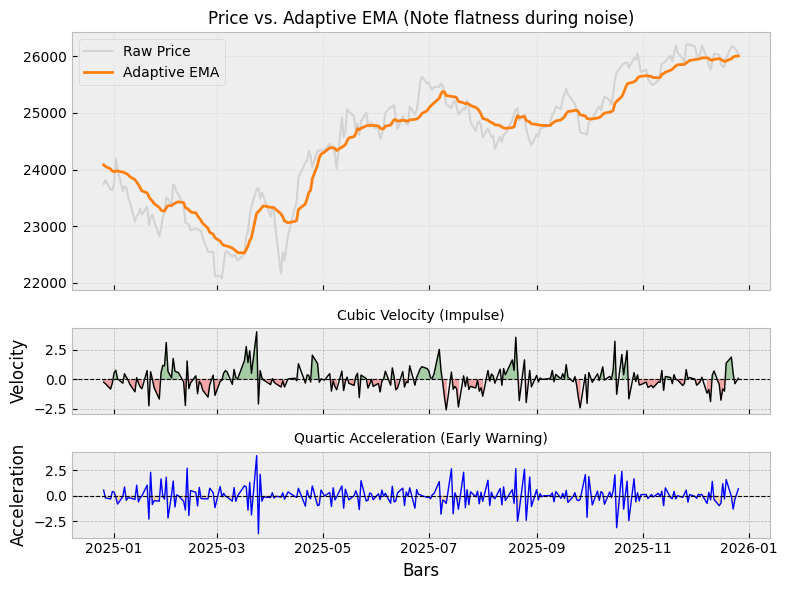

In [61]:
df['Vel_Z'] = standardize(df['AEMA_Vel'], window=20)
df['Accel_Z'] = standardize(df['AEMA_Accel'], window=20)
import matplotlib.pyplot as plt
plot_df = df.iloc[-250:].copy()
# ==========================================
# 4. Matplotlib Visualization
# ==========================================
plt.style.use('bmh') # Clean visual style
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,6), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

# --- Plot 1: Price vs AEMA ---
ax1.plot(plot_df.index, plot_df['Close'], label='Raw Price', color='lightgray', linewidth=1.5)
ax1.plot(plot_df.index, plot_df['Adaptive_EMA'], label='Adaptive EMA', color='#ff7f0e', linewidth=2)
ax1.set_title("Price vs. Adaptive EMA (Note flatness during noise)", fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# --- Plot 2: Cubic Velocity ---
ax2.plot(plot_df.index, plot_df['Vel_Z'], color='black', linewidth=1)
# Fill colors for visual signal
ax2.fill_between(plot_df.index, plot_df['Vel_Z'], 0, where=(plot_df['Vel_Z'] >= 0), color='green', alpha=0.3)
ax2.fill_between(plot_df.index, plot_df['Vel_Z'], 0, where=(plot_df['Vel_Z'] < 0), color='red', alpha=0.3)
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax2.set_ylabel("Velocity")
ax2.set_title("Cubic Velocity (Impulse)", fontsize=10)

# --- Plot 3: Quartic Acceleration ---
ax3.plot(plot_df.index, plot_df['Accel_Z'], color='blue', linewidth=1)
ax3.axhline(0, color='black', linewidth=0.8, linestyle='--')
# Highlight deceleration warning
ax3.fill_between(plot_df.index, plot_df['Accel_Z'], 0, where=(plot_df['Accel_Z'] < 0), color='orange', alpha=0.3, label='Deceleration')
ax3.set_ylabel("Acceleration")
ax3.set_title("Quartic Acceleration (Early Warning)", fontsize=10)
ax3.set_xlabel("Bars")

plt.tight_layout()
plt.show()

In [62]:
def calculate_slope_angle(series, lookback=5):
    """
    Calculates the angle of the slope in degrees.
    Normalization: Uses Average True Range (ATR) or StdDev logic
    to make the slope comparable across different price ranges.
    """
    # 1. Calculate raw difference (Rise)
    # We look at the change over 'lookback' bars to stabilize the angle
    delta_y = series - series.shift(lookback)

    # 2. Normalize the difference
    # We divide by the price itself to get percentage change,
    # then scale it up (e.g., by 100) to get a usable number.
    # Alternatively, divide by ATR if available. Here we use % change.
    delta_y_norm = (delta_y / series.shift(lookback)) * 1000

    # 3. Calculate Run (Time)
    delta_x = lookback

    # 4. Calculate Angle (Arctan)
    # Result is in Radians, convert to Degrees
    angle_rad = np.arctan(delta_y_norm / delta_x)
    angle_deg = np.degrees(angle_rad)

    return angle_deg

# Usage:
df['AEMA_Angle'] = calculate_slope_angle(df['Adaptive_EMA'], lookback=3)

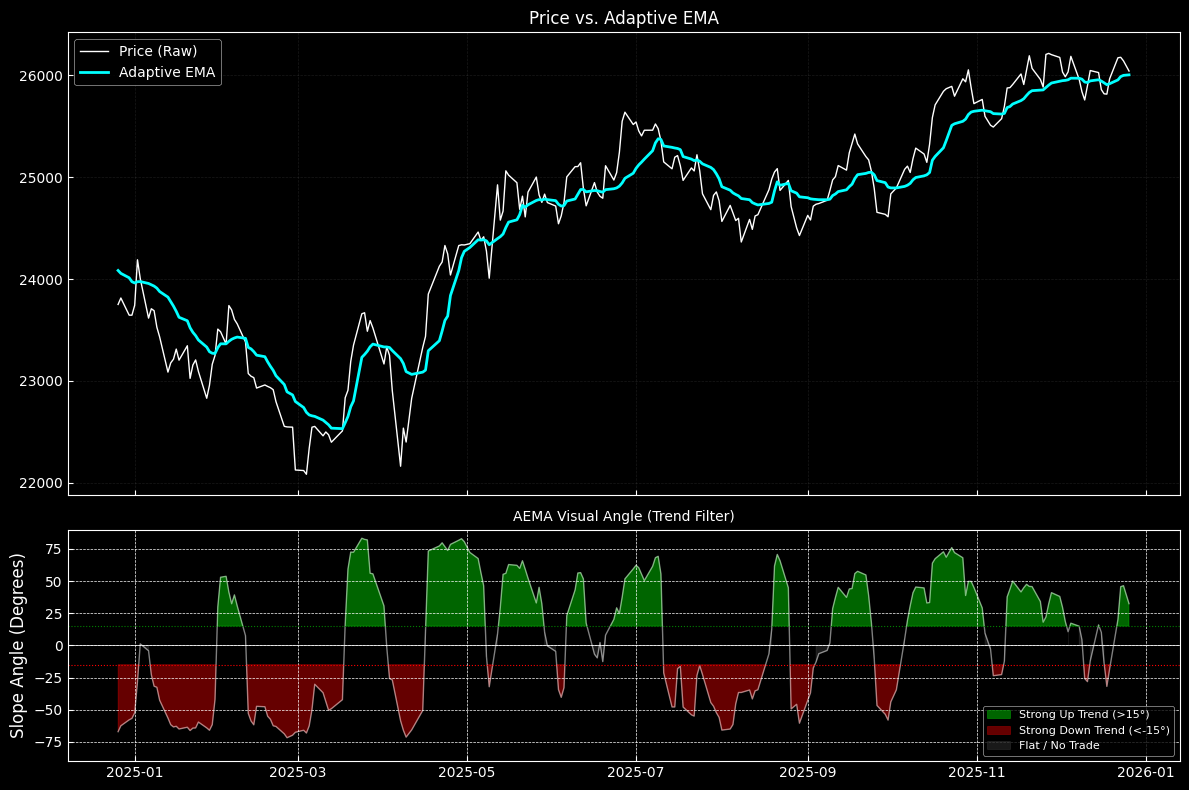

In [66]:
# Filter startup noise
plot_df = df.iloc[-250:].copy()

# ==========================================
# 4. Visualization
# ==========================================
plt.style.use('dark_background') # Easier on the eyes for angle analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# --- Top Panel: Price vs AEMA ---
ax1.plot(plot_df.index, plot_df['Close'], color='white', label='Price (Raw)', linewidth=1)
ax1.plot(plot_df.index, plot_df['Adaptive_EMA'], color='cyan', label='Adaptive EMA', linewidth=2)
ax1.set_title("Price vs. Adaptive EMA", fontsize=12, color='white')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.1)

# --- Bottom Panel: AEMA Angle ---
# Color logic: Green for > 15 deg, Red for < -15 deg, Gray for Flat
angle_values = plot_df['AEMA_Angle'].values
x_axis = plot_df.index.values

# Plot the main line
ax2.plot(x_axis, angle_values, color='white', linewidth=1, alpha=0.5)

# Fill areas based on Angle Strength
ax2.fill_between(x_axis, angle_values, 15, where=(angle_values > 15),
                 interpolate=True, color='#00ff00', alpha=0.4, label='Strong Up Trend (>15°)')

ax2.fill_between(x_axis, angle_values, -15, where=(angle_values < -15),
                 interpolate=True, color='#ff0000', alpha=0.4, label='Strong Down Trend (<-15°)')

ax2.fill_between(x_axis, angle_values, 0, where=((angle_values <= 15) & (angle_values >= -15)),
                 interpolate=True, color='gray', alpha=0.2, label='Flat / No Trade')

# Reference lines
ax2.axhline(15, color='green', linestyle=':', linewidth=0.8)
ax2.axhline(-15, color='red', linestyle=':', linewidth=0.8)
ax2.axhline(0, color='white', linestyle='-', linewidth=0.5)

ax2.set_ylabel("Slope Angle (Degrees)")
ax2.set_title("AEMA Visual Angle (Trend Filter)", fontsize=10, color='white')
ax2.legend(loc='lower right', fontsize=8)
ax2.set_ylim(-90, 90) # Standardize view

plt.tight_layout()
plt.show()